In [5]:
import tqdm, torch, json, pickle, os, gc, time
import pandas as pd
import numpy as np
from collections import OrderedDict
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation
from src.utils.visualization import plot_scatter
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import seaborn as sns
from pathlib import Path


/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [6]:
train_ds = FPolyDatasetV2()
train_ds.generate('./data/fpolymers_221123.train.csv')
test_ds = FPolyDatasetV2()
test_ds.generate('./data/fpolymers_221123.test.csv')
cv = CrossValidation(n_fold=5, n_data=len(train_ds), return_index=True)

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data


In [8]:
def vector_from_atom_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = global_mean_pool(f['atom_feat'], f['graph_idx'])
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def vector_from_mol_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = f['mol_feat']
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def obj_fnc(eta, max_depth):
    global train_data, valid_data, test_data, m_best, best
    params = {
        'max_depth':int(np.round(max_depth)),
        'min_child_weight': 1,
        'eta':eta,
        # Other parameters
        'objective':'reg:squarederror',
        'eval_metric':'mae'
    }
    booster = xgb.train(params, dtrain=train_data, num_boost_round=50, early_stopping_rounds=5, 
                        evals=[(valid_data, 'valid')], verbose_eval=False)
    tt = train_data.get_label()
    vt = valid_data.get_label()
    tp = booster.predict(train_data, iteration_range=(0, booster.best_iteration+1))
    vp = booster.predict(valid_data, iteration_range=(0, booster.best_iteration+1))
    train_r2, train_mae = r2_score(tt, tp), mean_absolute_error(tt, tp)
    valid_r2, valid_mae = r2_score(vt, vp), mean_absolute_error(vt, vp)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        ft = test_data.get_label()
        fp = booster.predict(test_data, iteration_range=(0, booster.best_iteration+1))
        m_best = m
        best = {'params':params, 'train':[tt, tp], 'valid':[vt, vp], 'test':[ft, fp]}
    return m

In [9]:
train_af, train_tgt, train_ids = vector_from_atom_feat(train_ds)
test_af, test_tgt, test_ids = vector_from_atom_feat(test_ds)

train_mf, train_tgt, train_ids = vector_from_mol_feat(train_ds)
test_mf, test_tgt, test_ids = vector_from_mol_feat(test_ds)

features = {
    'graph':[train_af, test_af],
    'global':[train_mf, test_mf],
    'both':[np.hstack([train_af, train_mf]), np.hstack([test_af, test_mf])],
}

In [17]:

outputs = {}
for i in range(5):
    output = {}
    train_idx, valid_idx = cv[i]
    for feature_type, (train_feat, test_feat) in features.items():
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(obj_fnc, pbounds={'eta':[1e-2,1], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=140)
        tt, tp = best['train']
        vt, vp = best['valid']
        ft, fp = best['test']
        vals = [
            r2_score(tt, tp), np.sqrt(mean_squared_error(tt, tp)), mean_absolute_error(tt, tp),
            r2_score(vt, vp), np.sqrt(mean_squared_error(vt, vp)), mean_absolute_error(vt, vp),
            r2_score(ft, fp), np.sqrt(mean_squared_error(ft, fp)), mean_absolute_error(ft, fp)
        ]
        print('Fold: {} : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(i, *vals))
        output[feature_type] = best.copy(), vals
    outputs[i] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))


Fold: 0 :   0.931 /  7.80 /  5.82 |   0.577 / 20.32 / 14.71 |  -0.422 / 21.01 / 15.17 | 
Fold: 0 :   0.989 /  3.12 /  2.03 |   0.555 / 20.85 / 15.68 |   0.020 / 17.45 / 12.81 | 
Fold: 0 :   0.979 /  4.36 /  3.20 |   0.523 / 21.57 / 15.29 |   0.240 / 15.36 / 10.92 | 
Fold: 1 :   0.992 /  2.75 /  0.84 |   0.447 / 20.79 / 16.08 |  -0.397 / 20.83 / 15.67 | 
Fold: 1 :   0.998 /  1.27 /  0.51 |   0.682 / 15.76 / 11.28 |   0.180 / 15.96 / 11.78 | 
Fold: 1 :   0.998 /  1.19 /  0.37 |   0.696 / 15.41 / 10.99 |   0.153 / 16.22 / 11.37 | 
Fold: 2 :   0.987 /  3.50 /  1.58 |   0.386 / 23.47 / 16.81 |  -0.091 / 18.40 / 13.97 | 
Fold: 2 :   0.996 /  1.97 /  1.19 |   0.498 / 21.22 / 15.98 |   0.341 / 14.31 / 11.42 | 
Fold: 2 :   0.997 /  1.77 /  1.05 |   0.497 / 21.24 / 15.79 |   0.312 / 14.62 / 11.46 | 
Fold: 3 :   0.996 /  1.97 /  0.31 |   0.437 / 20.76 / 15.84 |  -0.621 / 22.44 / 17.39 | 
Fold: 3 :   0.998 /  1.30 /  0.25 |   0.656 / 16.23 / 11.60 |   0.064 / 17.05 / 12.14 | 
Fold: 3 :   0.998 /  

In [18]:
with open('xgb.output.new.pkl','wb') as f:
    pickle.dump(outputs, f)

In [3]:
import pickle
import numpy as np
with open('xgb.output.new.pkl','rb') as f:
    out = pickle.load(f)

In [4]:
mapper = {0:'graph',1:'global',2:'both'}
best_output = [vv[mapper[np.argmax([v[1][3] for v in vv.values()])]] for vv in out.values()]
np.array([v[1] for v in best_output]).T


array([[ 0.9313911 ,  0.99849307,  0.99576522,  0.99828544,  0.99225426],
       [ 7.80236864,  1.19150865,  1.96508801,  1.27512348,  2.59004521],
       [ 5.81562853,  0.37259755,  1.1887188 ,  0.13314261,  1.66947973],
       [ 0.57710348,  0.69640202,  0.49778907,  0.68143741,  0.67564359],
       [20.3159771 , 15.40592575, 21.22265434, 15.61379242, 18.5825367 ],
       [14.70554447, 10.99380589, 15.98180389, 11.71816826, 13.35301208],
       [-0.42159659,  0.1534201 ,  0.34088057,  0.13005657,  0.13118625],
       [21.01244164, 16.21520042, 14.30771828, 16.43742752, 16.42675209],
       [15.17410374, 11.37425518, 11.42078018, 12.12417126, 12.39547062]])

In [10]:
r2_score(test_tgt, np.mean([v[0]['test'][1] for v in best_output], 0)), mean_absolute_error(test_tgt, np.mean([v[0]['test'][1] for v in best_output], 0))

(0.3311809439062332, 10.788781)

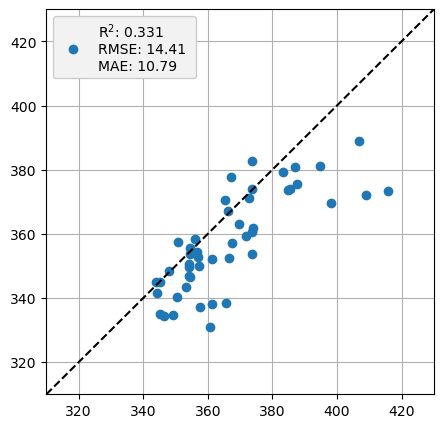

In [107]:
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  np.mean([v[0]['test'][1] for v in best_output], 0) + 273.15, xrange = [310, 430])
f.savefig('./output.xgb.test.pdf')

In [90]:
from sklearn.svm import SVR
bests = [None]*5
preds = [None]*5
for i in range(5):
    record = -50
    train_idx, valid_idx = cv[i]
    for ftyp, (feat, x_test) in features.items():
        x_train = feat[train_idx]
        x_valid = feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            svr = SVR(kernel=kernel, C=100, gamma='auto')
            svr.fit(x_train, y_train.reshape(-1))
            p_train = svr.predict(x_train)
            p_valid = svr.predict(x_valid)
            p_test = svr.predict(x_test)

            vals = [
                r2_score(y_train, p_train), np.sqrt(mean_squared_error(y_train, p_train)), mean_absolute_error(y_train, p_train),
                r2_score(y_valid, p_valid), np.sqrt(mean_squared_error(y_valid, p_valid)), mean_absolute_error(y_valid, p_valid),
                r2_score(test_tgt, p_test), np.sqrt(mean_squared_error(test_tgt, p_test)), mean_absolute_error(test_tgt, p_test)
            ]
            print('Fold: {} : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(i, *vals))
            if vals[3] > record:
                bests[i] = vals
                preds[i] = [p_train, p_valid, p_test]
                record = vals[3]


Fold: 0 :   0.274 / 25.37 / 18.99 |   0.391 / 24.39 / 19.51 |  -0.320 / 20.25 / 14.70 | 
Fold: 0 :   0.439 / 22.32 / 15.73 |   0.462 / 22.92 / 17.59 |  -0.063 / 18.17 / 14.39 | 
Fold: 0 :   0.323 / 24.52 / 17.61 |   0.266 / 26.76 / 20.79 |  -0.987 / 24.84 / 20.21 | 
Fold: 0 :  -0.000 / 29.79 / 23.66 |  -0.046 / 31.95 / 26.33 |  -3.008 / 35.28 / 30.56 | 
Fold: 0 :   0.759 / 14.62 /  8.16 |   0.504 / 22.00 / 15.27 |  -0.523 / 21.75 / 14.23 | 
Fold: 0 :   0.763 / 14.51 /  7.65 |   0.403 / 24.14 / 16.56 |   0.533 / 12.05 /  8.73 | 
Fold: 0 :   0.605 / 18.72 / 11.38 |   0.439 / 23.40 / 17.14 |   0.221 / 15.56 / 11.42 | 
Fold: 0 : -55.875 / 224.64 / 120.26 | -70.387 / 263.95 / 120.90 | -202.236 / 251.24 / 132.13 | 
Fold: 0 :   0.759 / 14.62 /  8.16 |   0.505 / 21.99 / 15.22 |  -0.536 / 21.84 / 14.24 | 
Fold: 0 :   0.776 / 14.11 /  7.23 |   0.341 / 25.36 / 17.02 |   0.468 / 12.86 /  9.01 | 
Fold: 0 :   0.601 / 18.83 / 11.45 |   0.440 / 23.39 / 17.04 |   0.193 / 15.83 / 11.64 | 
Fold: 0 : -18.

In [91]:
np.array(bests).T

array([[ 0.75927078,  0.79518696,  0.77219819,  0.59480799,  0.7916499 ],
       [14.61506122, 13.89088351, 14.41268727, 19.60229293, 13.43299045],
       [ 8.15717256,  7.77878169,  7.81817259, 12.0808108 ,  7.70470081],
       [ 0.5047368 ,  0.53881086,  0.58003276,  0.56717783,  0.56390375],
       [21.98561793, 18.98794247, 19.40726405, 18.19976435, 21.54690632],
       [15.2174544 , 13.86704203, 14.82957991, 13.37873667, 16.4638844 ],
       [-0.53607653,  0.17158943,  0.53902011,  0.21077993, -0.58492596],
       [21.84211881, 16.0402508 , 11.96545803, 15.65623744, 22.18670597],
       [14.23896412, 10.21502932,  8.85987103, 11.91443095, 13.01575012]])

In [100]:
pe = np.mean([p[2] for p in preds], 0)
r2_score(test_tgt.reshape(-1), pe), mean_absolute_error(test_tgt.reshape(-1), pe)

(0.5229110654315048, 8.855135538458915)

In [104]:
np.abs(test_tgt.reshape(-1) - pe).mean()

8.855135538458915

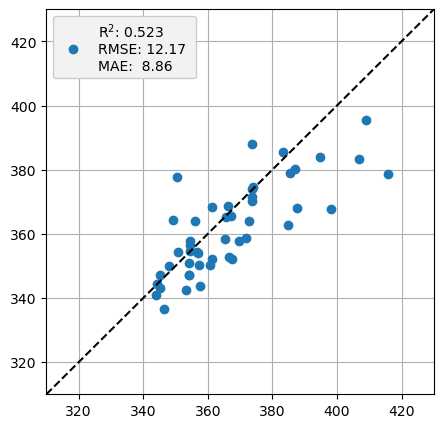

In [106]:
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_scatter(ax, test_tgt.reshape(-1) + 273.15,  pe + 273.15, xrange = [310, 430])
